In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)    

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

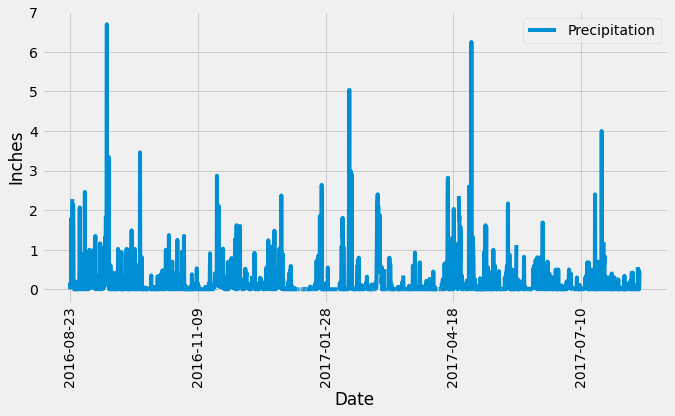

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.

# Use datetime to convert it to a datetime object and then use relativedelta imported from dateutil to subtract one year
recent_datetime = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
last_year_datetime = recent_datetime - relativedelta(years=1)
last_year = dt.datetime.strftime(last_year_datetime, '%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

measurements = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= last_year).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

measurement_df = pd.DataFrame(measurements, columns=['id','station','date','prcp','tobs'])
measurement_df.set_index('date', inplace=True)

# Sort the dataframe by date

measurement_df.sort_index

# Use Pandas Plotting with Matplotlib to plot the data

measurement_df.plot(y=['prcp'], figsize=[10,5], ylabel="Inches", xlabel="Date", rot=90).legend(["Precipitation"])


In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data

measurement_df[['prcp','tobs']].describe()

,prcp,tobs
count,2021.000000,2230.000000
mean,0.177279,74.590583
std,0.461190,4.611667
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number stations in the dataset

session.query(Station.id).count()

9

In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
    
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Using the query from the last section I add [0][0] to get the station name
# First [0] gets the first element in the query, second [0] gets the station ID as a string
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()[0][0]
station_name = session.query(Station.name).filter(Station.station == most_active_station)[0][0]

# Now that I have the most active station I filter Measurement.station is equal to that station name
# The session query returns a tuple so again I add [0][0] to the end to get the actual number
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station)[0][0]
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station)[0][0]
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)[0][0]

print(f"""
Station Name: {station_name}

Lowest Temperature: {lowest_temp}
Highest Temperatrue: {highest_temp}
Average Temperature: {average_temp}""")




Station Name: WAIHEE 837.5, HI US

Lowest Temperature: 54.0
Highest Temperatrue: 85.0
Average Temperature: 71.66378066378067


<AxesSubplot:ylabel='Frequency'>

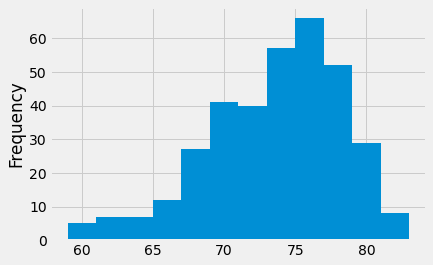

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_measurements = session.query(Measurement.id, Measurement.date, Measurement.tobs).filter(Measurement.date > last_year, Measurement.station == most_active_station).order_by(Measurement.date).all()
most_active_measurements_df = pd.DataFrame(most_active_station_measurements, columns=['ID','date','tobs'])
most_active_measurements_df['tobs'].plot(kind='hist', bins=12)

# Close session

In [20]:
# Close Session
session.close()